In [ ]:
import os
import sys
import numpy as np
import pandas as pd
import torch
import pyro
import warnings
from typing import List, Tuple
from tqdm.autonotebook import tqdm
import matplotlib.pyplot as plt
import seaborn as sns

from matplotlib import rc
from tqdm.autonotebook import tqdm
rc("font", **{"family": "serif", "serif": ["Computer Modern"], "size": 18})
rc("text", usetex=True)

sys.path.append("../../../")
warnings.filterwarnings("ignore")

from bannane.src.config import Config
from bannane.src.data_loader import MultiIsotopeDataLoader
from bannane.src.preprocess import split_data_multi_isotope

# Training a BANNANE Emulator

## Training the model

Lets set up the folders to store the data and the model.

In [2]:
logs_dir = '../../../_results/objects'
if not os.path.exists(logs_dir):
    os.makedirs(logs_dir)

config = Config()

config.data_directory = '../../DATA/all_o'
config.file_pattern = "*_radii.csv"

config.model_save_path = logs_dir + '/model.pth'
config.temperature_save_path = logs_dir + '/temperature.pth'
config.scaler_X_path = logs_dir + '/scaler_X.pth'
config.scaler_y_path = logs_dir + '/scaler_y.pth'

config.patience = 200
config.lr_patience = 20
config.lr_decay = 2.

config.shared_latent_dim = 128
config.hidden_dim = 64

config.num_heads = 2
config.fidelity_embedding_dim = 8

config.num_iterations = 30_000
config.dropout = 0.1
config.learning_rate = 1e-4

config.loss_weights = {4: 1.0, 6: 1.5, 8: 2.0, 10: 2.5}

In [ ]:
torch.manual_seed(config.seed)
np.random.seed(config.seed)
pyro.set_rng_seed(config.seed)

loader = MultiIsotopeDataLoader(config)
full_data = loader.load_all_data()

train_df, val_df, test_df = split_data_multi_isotope(full_data, config)


[DataLoader] Found 13 files matching the pattern.
[DataLoader] Combined data shape: (17234, 35)
[Preprocess] Data split => train: (11029, 35), val: (2758, 35), test: (3447, 35)


In [14]:
train_counts = train_df.groupby('emax').size().rename("Training")
val_counts = val_df.groupby('emax').size().rename("Validation")
test_counts = test_df.groupby('emax').size().rename("Testing")

fidelity_counts = pd.concat([train_counts, val_counts, test_counts], axis=1).fillna(0).astype(int)
print(fidelity_counts)

      Training  Validation  Testing
emax                               
4         3882         913     1112
6         3318         860     1090
8         3154         773     1026
10         675         212      219


In [ ]:
train_counts = train_df.groupby(['emax', 'N']).size().rename("Training")
val_counts = val_df.groupby(['emax', 'N']).size().rename("Validation")
test_counts = test_df.groupby(['emax', 'N']).size().rename("Testing")

counts_per_N = pd.concat([train_counts, val_counts, test_counts], axis=1).fillna(0).astype(int)

In [25]:
# Group counts_per_N by the second level (N) and sum the counts
total_samples_per_N = counts_per_N.groupby(level=1).sum()
print(total_samples_per_N)

    Training  Validation  Testing
N                                
4        826         207      252
5        779         210      249
6       1347         324      432
7        816         219      258
8        715         184      219
9        807         189      244
10       815         177      265
11       838         184      258
12       811         223      250
13       825         202      258
14       816         220      251
15       821         222      242
16       813         197      269


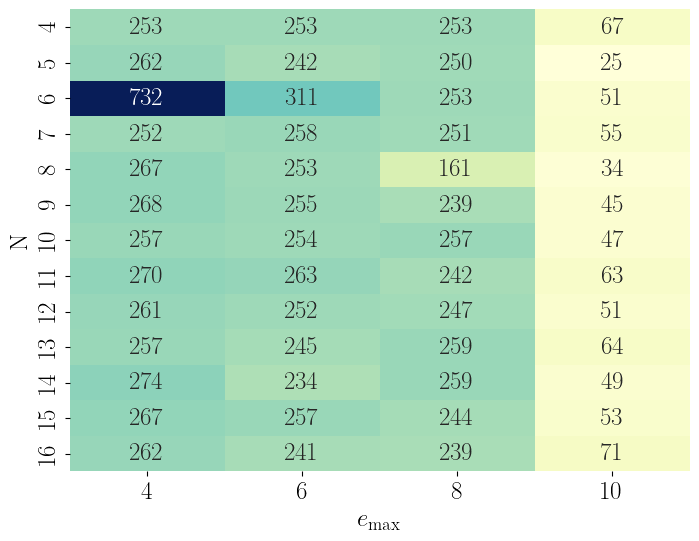

In [ ]:
heat_train = train_counts.unstack(level=0)

fig, ax = plt.subplots(figsize=(8, 6))
sns.heatmap(heat_train, annot=True, fmt="d", cmap="YlGnBu")
ax.set_xlabel(r"$e_{\max}$")
ax.set_ylabel("N")
ax.collections[0].colorbar.remove()